In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
np.warnings.filterwarnings('ignore')
import datetime
import os
import math
import torch
import gpytorch

import excursion

import excursion.testcases.fast_1D as testcase_details
import excursion.optimize
import excursion.active_learning as active_learning

from excursion.utils import get_first_max_index,point_entropy, mesh2points, points2mesh, values2mesh

import excursion.plotting.onedim as plots
#import excursion.utils as utils

import matplotlib.pyplot as plt
%matplotlib inline

# 0) Init
True frunctions, grid, training data

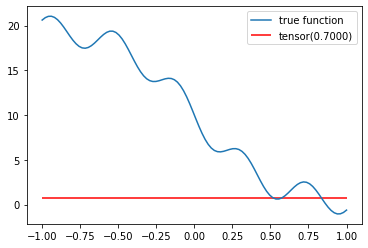

In [3]:
#init true functions + thresholds
for func in testcase_details.true_functions:
    X_plot = testcase_details.plot_X
    plt.plot(X_plot, func(X_plot), label='true function')
    
for thr in testcase_details.thresholds:
    min_X = torch.min(testcase_details.plot_X)
    max_X = torch.max(testcase_details.plot_X)
    plt.hlines(thr, min_X, max_X, colors = 'red', label=str(thr))

plt.legend(loc=0 )

In [4]:
#init grid
X_grid = testcase_details.X
print('X_grid ', X_grid.shape)

X_grid  torch.Size([100, 1])


In [5]:
#init training data
torch.manual_seed(2)
num_points = 2

X_train = torch.Tensor([])
for dim in range(testcase_details.n_dims):
    upper = testcase_details.rangedef[dim][0]
    lower = testcase_details.rangedef[dim][1]
    random_sample = torch.distributions.Uniform(upper,lower).rsample((num_points,))
    
    X_train = torch.cat((X_train,random_sample),0)
    y_train = testcase_details.true_functions[0](random_sample)

#X_train = torch.tensor([[-0.16595599],[ 0.44064899]])
#y_train = testcase_details.true_functions[0](X_train)

print('X_0 = ', X_train, X_train.shape)
print('f(X_0) = ', y_train, y_train.shape)

X_0 =  tensor([ 0.2294, -0.2380]) torch.Size([2])
f(X_0) =  tensor([ 6.1513, 13.8073]) torch.Size([2])


# 1) GP model selection
To choose between ExactGP or GridRegression + Exact GP
Choose prior

In [6]:
# simplest form of GP model RBF with constant mean prior, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(\
                            gpytorch.kernels.RBFKernel(\
                            lengthscale_constraint=gpytorch.constraints.GreaterThan(lower_bound=0.1)
                            ))
                                                      

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 2) Likelihood selection

In [7]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor([0.])) 

# 3) Fit model with training points

In [8]:
model = ExactGPModel(X_train, y_train, likelihood)

In [9]:
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

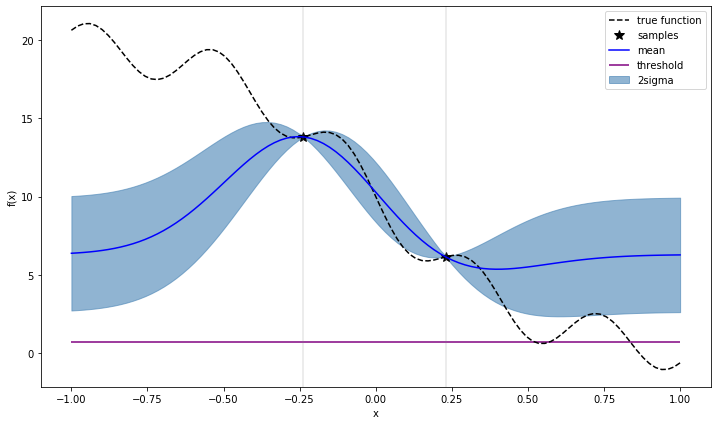

In [10]:
plots.plot_GP(model, testcase_details);

# 4) acquisition function selection

In [11]:
acq_type = 'PES' #predictive entropy search

# 5) Smart grid seach (active learning)

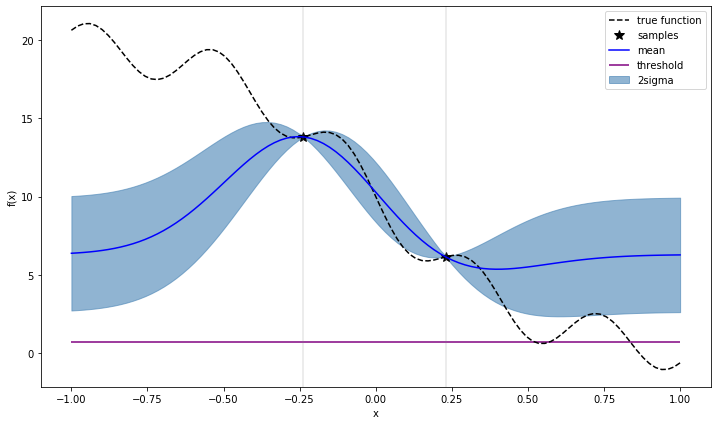

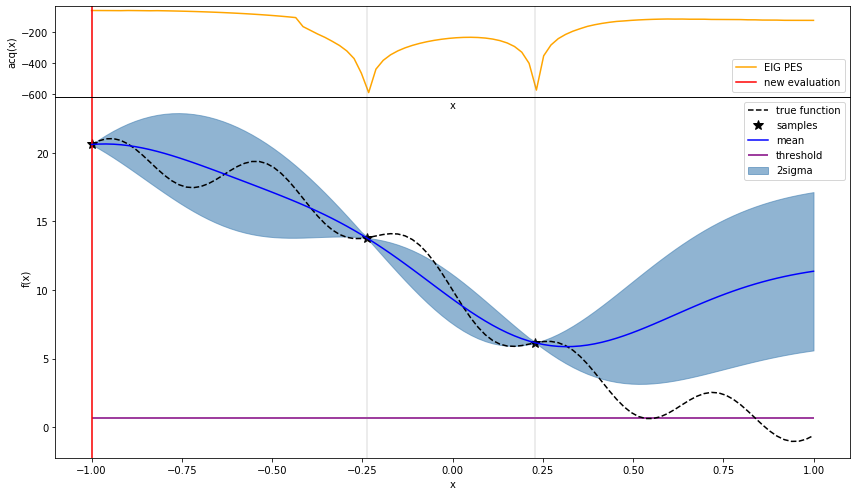

Iteration 0, x_new tensor([[-1.]]) 



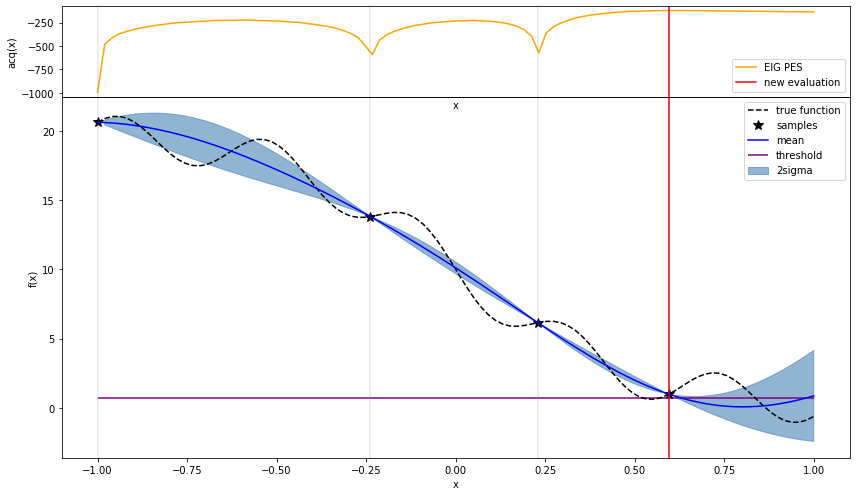

Iteration 1, x_new tensor([[0.5960]]) 



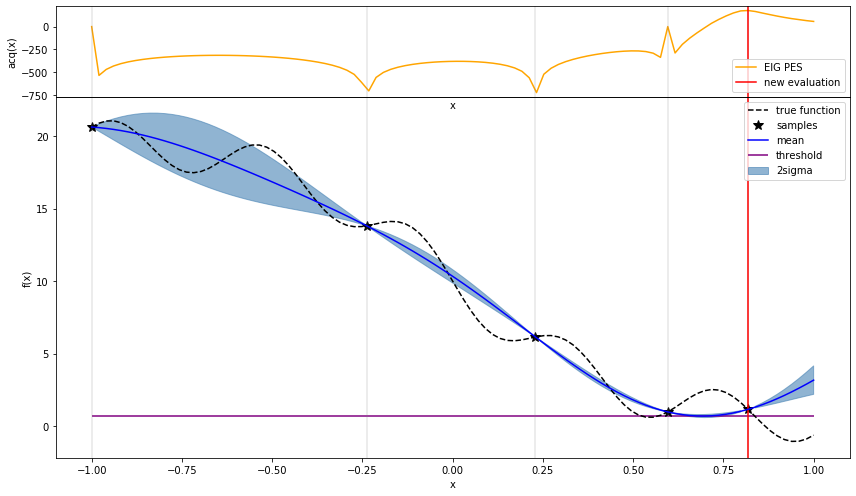

Iteration 2, x_new tensor([[0.8182]]) 



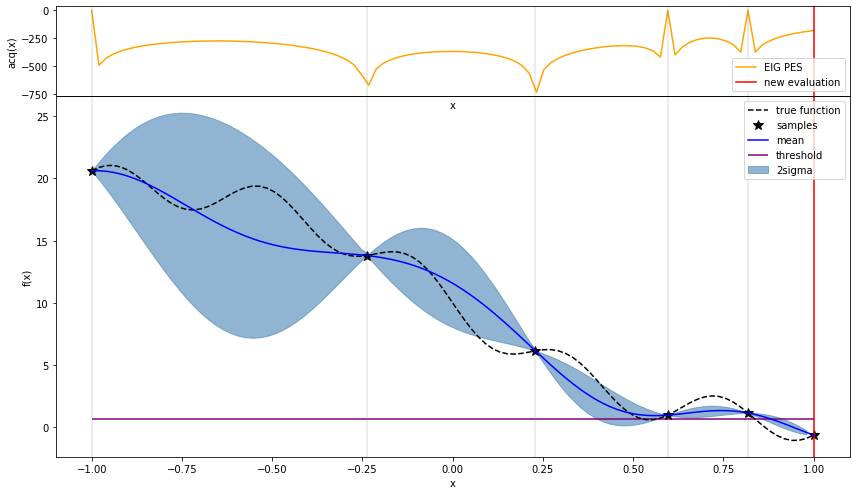

Iteration 3, x_new tensor([[1.]]) 



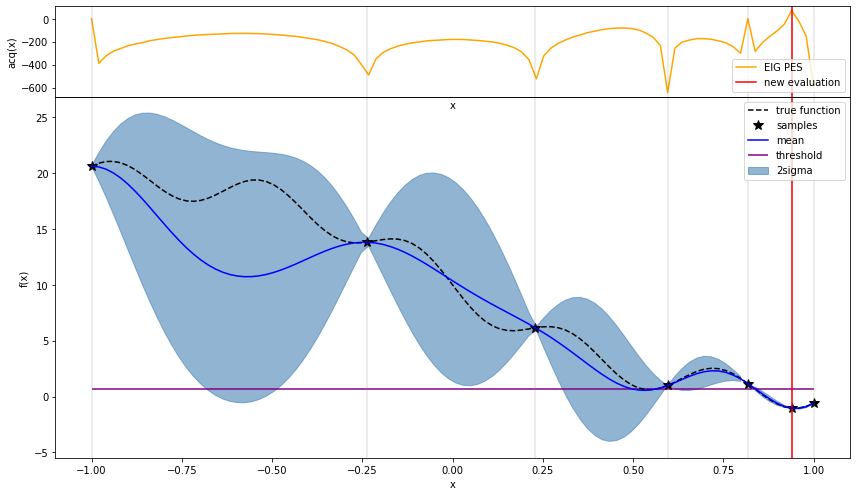

Iteration 4, x_new tensor([[0.9394]]) 



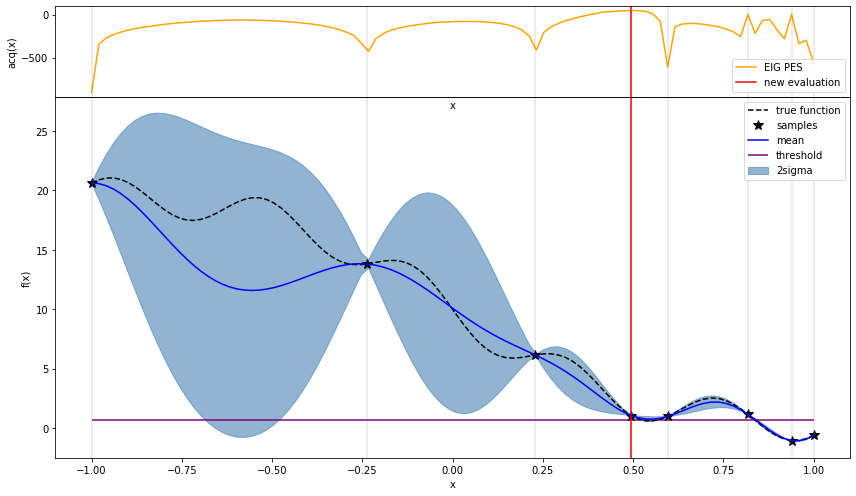

Iteration 5, x_new tensor([[0.4949]]) 



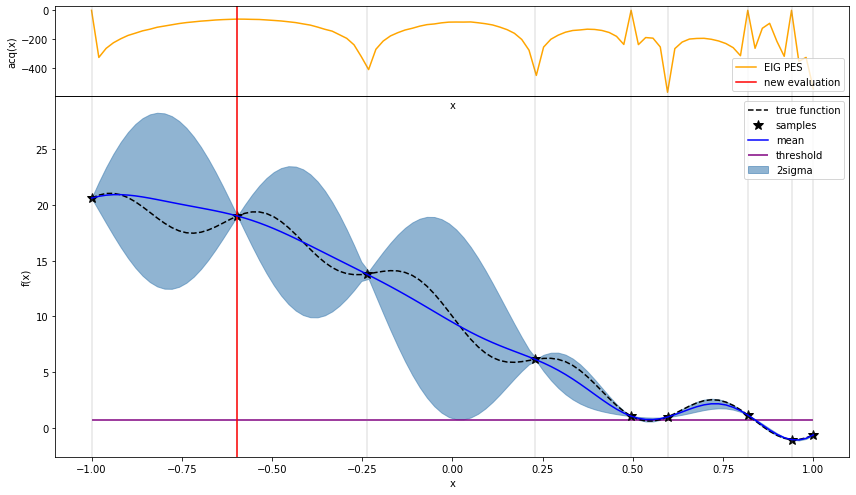

Iteration 6, x_new tensor([[-0.5960]]) 



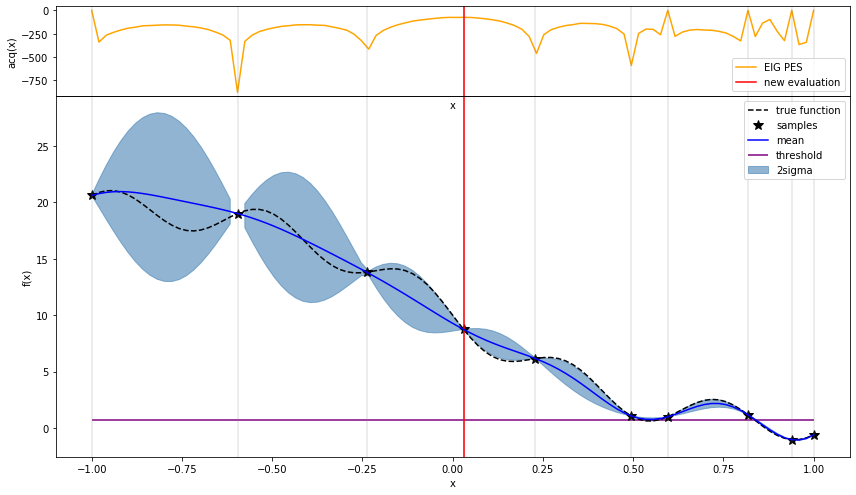

Iteration 7, x_new tensor([[0.0303]]) 



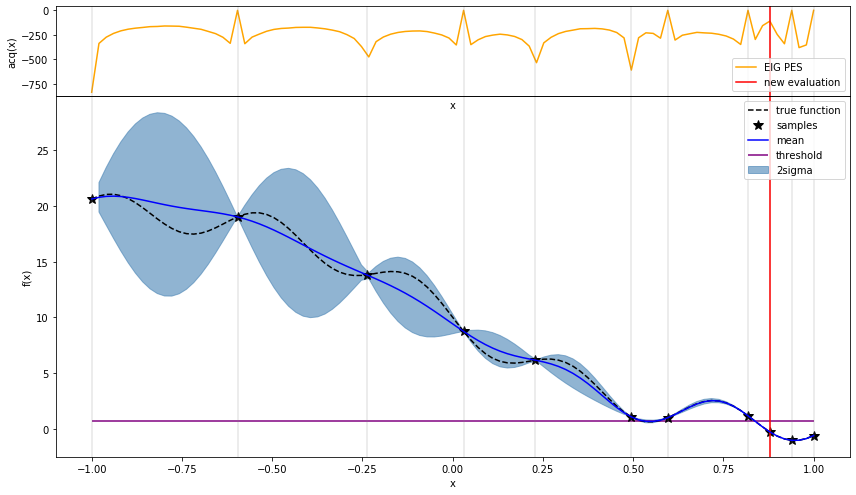

Iteration 8, x_new tensor([[0.8788]]) 



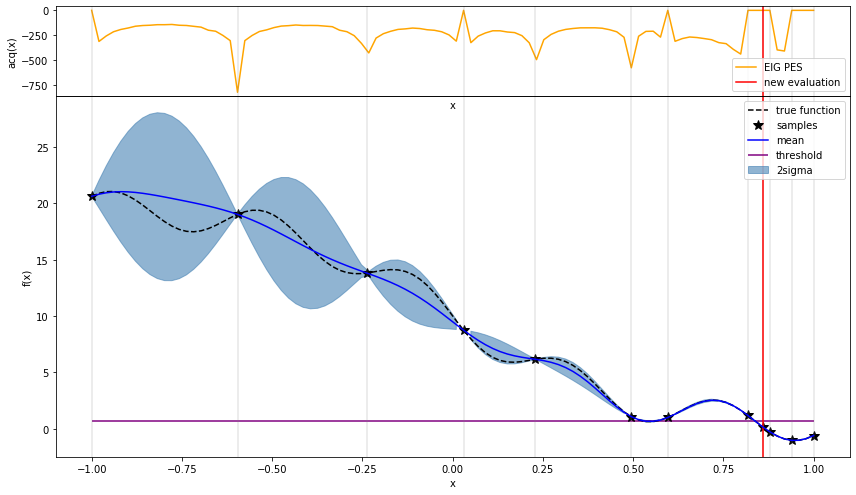

Iteration 9, x_new tensor([[0.8586]]) 



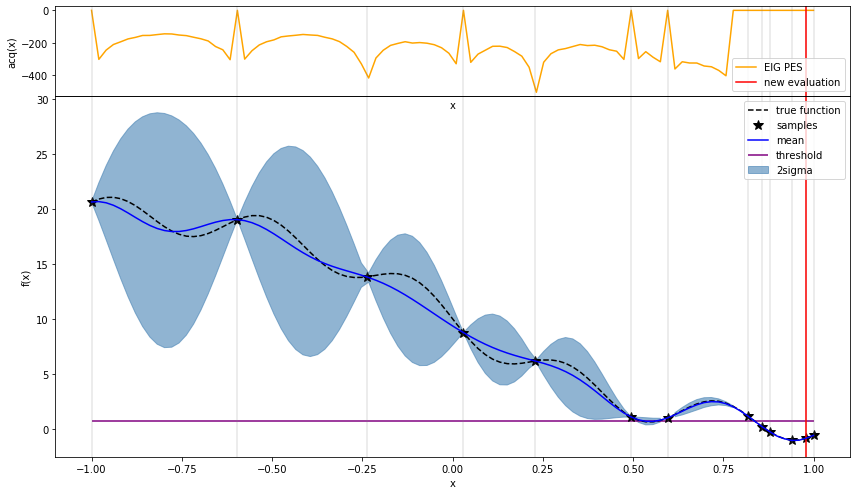

Iteration 10, x_new tensor([[0.9798]]) 



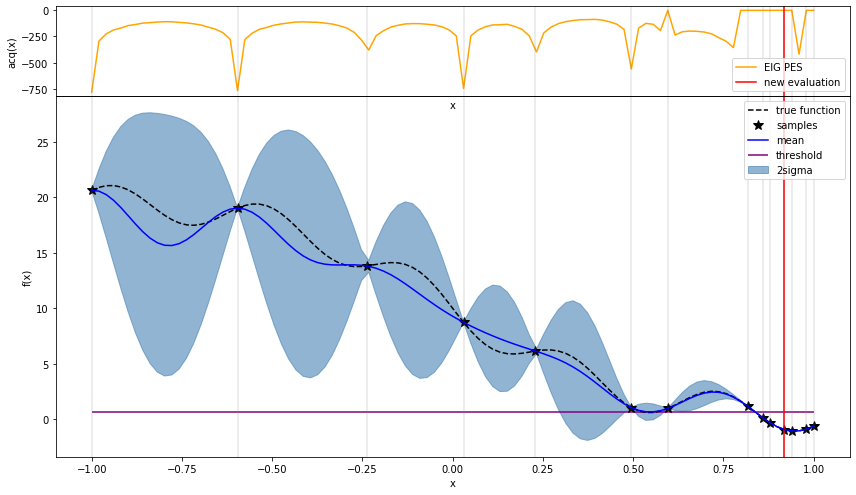

Iteration 11, x_new tensor([[0.9192]]) 



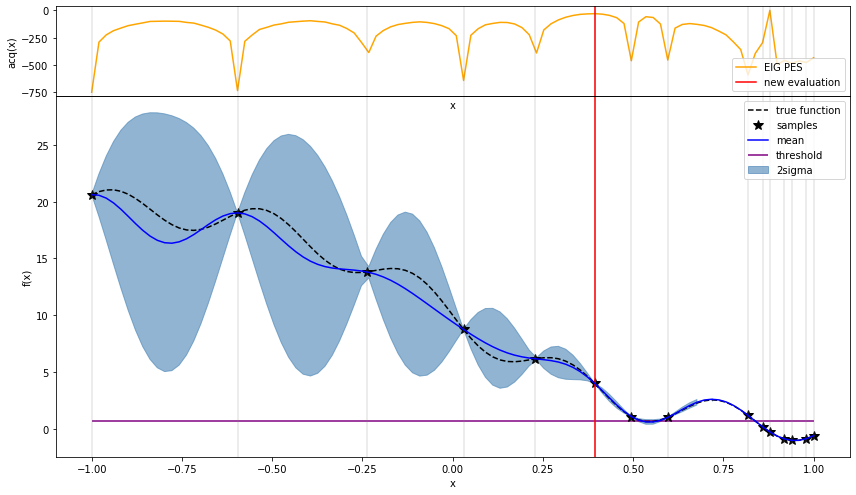

Iteration 12, x_new tensor([[0.3939]]) 



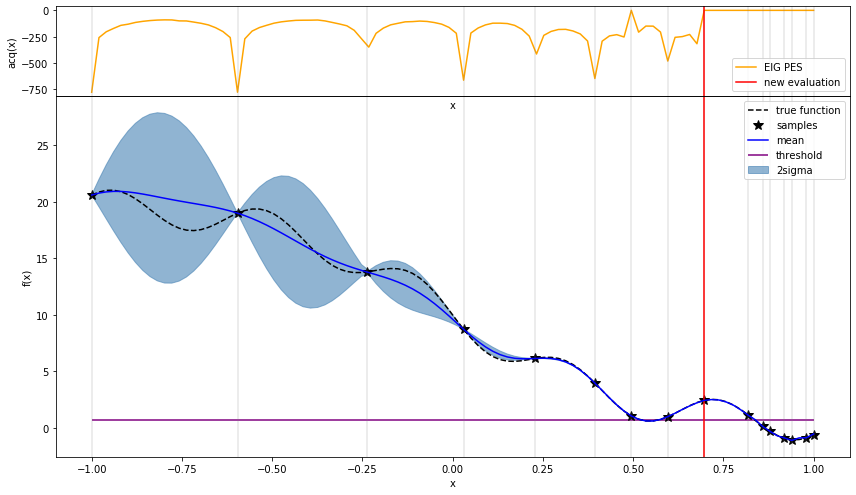

Iteration 13, x_new tensor([[0.6970]]) 



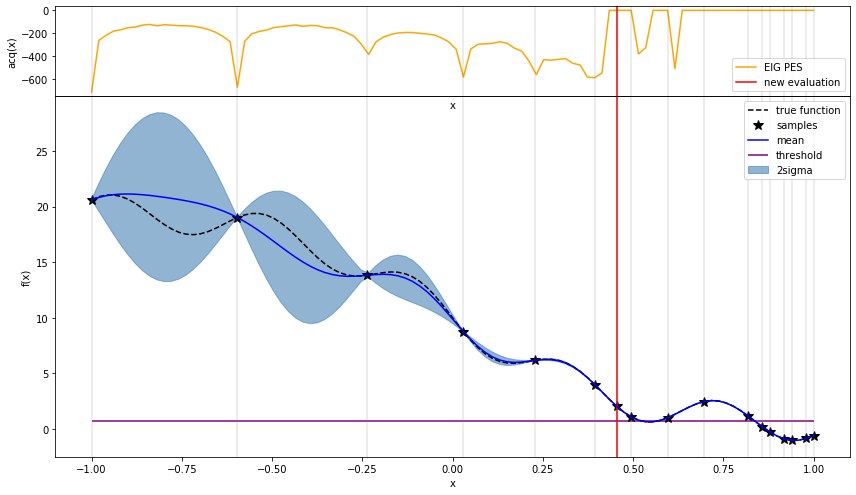

Iteration 14, x_new tensor([[0.4545]]) 



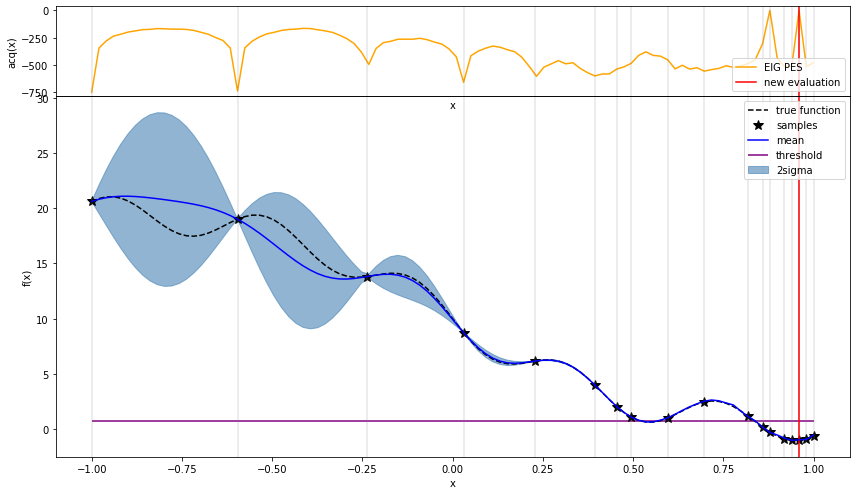

Iteration 15, x_new tensor([[0.9596]]) 



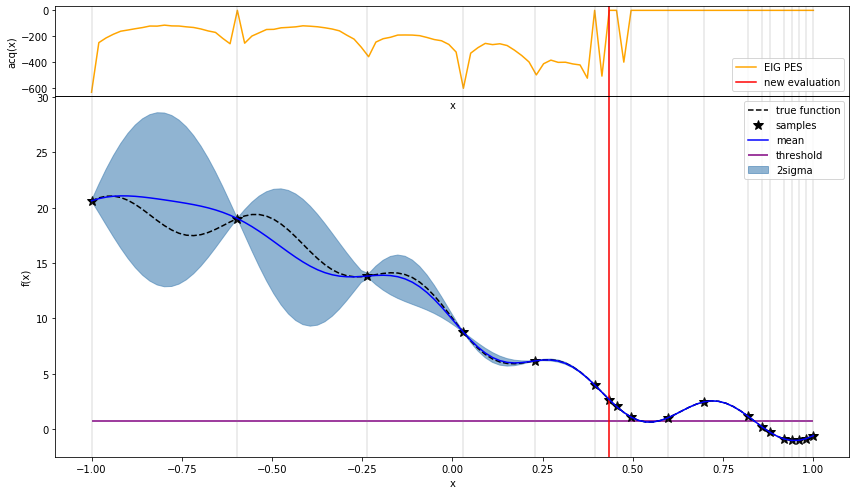

Iteration 16, x_new tensor([[0.4343]]) 



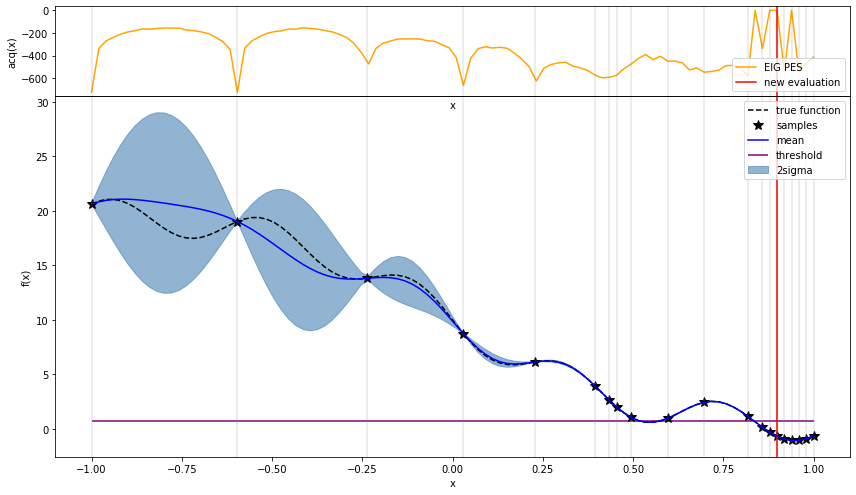

Iteration 17, x_new tensor([[0.8990]]) 



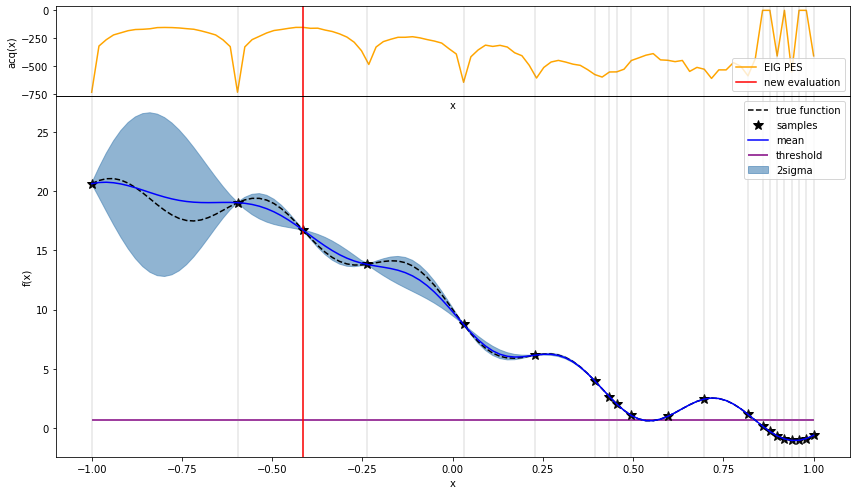

Iteration 18, x_new tensor([[-0.4141]]) 



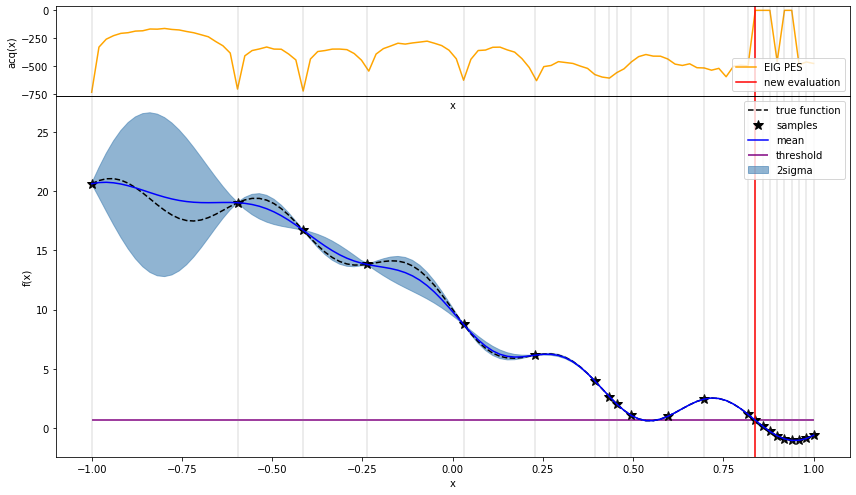

Iteration 19, x_new tensor([[0.8384]]) 



In [12]:
n_iter = 20

plots.plot_GP(model, testcase_details) 

for i in range(n_iter):
    
    #find x_new by maximizing acq)(x)
    acquisition_values_grid = []
    for x in X_grid:
        value = active_learning.acq(model,testcase_details, x, acq_type)
        acquisition_values_grid.append(value)
        
    new_indexs = np.argsort(acquisition_values_grid)[::-1] #descending order
        
    ##discard those points already in dataset
    new_index = get_first_max_index(model, new_indexs, testcase_details)
    
    ##get x, y
    x_new = testcase_details.X[new_index].view(-1,1)
    y_new = testcase_details.true_functions[0](x_new)
    
    #update dataset
    inputs_i = torch.cat((model.train_inputs[0], x_new),0).flatten()
    targets_i = torch.cat((model.train_targets.view(-1,1), y_new),0).flatten()
    model.set_train_data(inputs=inputs_i, targets=targets_i, strict=False)
    
    #fit posterior with new dataset
    model.train()
    likelihood.train()
    excursion.fit_hyperparams(model,likelihood)
    
    #plot and print
    
    plots.plot_GP(model, testcase_details, acq=acquisition_values_grid) 
    
    print('Iteration {}, x_new {} \n'.format(i,x_new))
    

In [13]:
model.eval()
likelihood.eval()
pred = likelihood(model(torch.tensor([0.2])))
type(pred)

gpytorch.distributions.multivariate_normal.MultivariateNormal

In [14]:
help(normal)

Help on built-in function normal:

normal(...) method of mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or "width") of the distribution.
    size : int or tuple of ints, optional
        Output shap

In [15]:
from torch import distributions.Normal as Normal
normal=Normal()

SyntaxError: invalid syntax (<ipython-input-15-97291598209d>, line 1)

In [ ]:
normal = torch.distributions.norm
normal.cdf(0)

In [ ]:
torch.is

In [ ]:
torch.isfinite(acquisition_values_grid)